In [1]:
from pyspark.sql import SparkSession
from pyspark import StorageLevel
import geopandas as gpd
import pandas as pd
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType
from pyspark.sql.types import LongType
from shapely.geometry import Point
from shapely.geometry import Polygon

from sedona.register import SedonaRegistrator
from sedona.core.SpatialRDD import SpatialRDD
from sedona.core.SpatialRDD import PointRDD
from sedona.core.SpatialRDD import PolygonRDD
from sedona.core.SpatialRDD import LineStringRDD
from sedona.core.enums import FileDataSplitter
from sedona.utils.adapter import Adapter
from sedona.core.spatialOperator import KNNQuery
from sedona.core.spatialOperator import JoinQuery
from sedona.core.spatialOperator import JoinQueryRaw
from sedona.core.spatialOperator import RangeQuery
from sedona.core.spatialOperator import RangeQueryRaw
from sedona.core.formatMapper.shapefileParser import ShapefileReader
from sedona.core.formatMapper import WkbReader
from sedona.core.formatMapper import WktReader
from sedona.core.formatMapper import GeoJsonReader
from sedona.sql.types import GeometryType
from sedona.core.enums import GridType
from sedona.core.SpatialRDD import RectangleRDD
from sedona.core.enums import IndexType
from sedona.core.geom.envelope import Envelope
from sedona.utils import SedonaKryoRegistrator, KryoSerializer




In [2]:
spark = SparkSession.\
    builder.\
    master("local[*]").\
    appName("Sedona App").\
    config("spark.serializer", KryoSerializer.getName).\
    config("spark.kryo.registrator", SedonaKryoRegistrator.getName) .\
    config("spark.jars.packages", "org.apache.sedona:sedona-python-adapter-3.0_2.12:1.1.0-incubating,org.datasyslab:geotools-wrapper:1.1.0-25.2") .\
    getOrCreate()

:: loading settings :: url = jar:file:/home/jovyan/spark-3.1.2-bin-hadoop3.2/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
org.apache.sedona#sedona-python-adapter-3.0_2.12 added as a dependency
org.datasyslab#geotools-wrapper added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-e5b4af28-8ba3-4c15-af64-a47d2d32afa0;1.0
	confs: [default]
	found org.apache.sedona#sedona-python-adapter-3.0_2.12;1.1.0-incubating in central
	found org.locationtech.jts#jts-core;1.18.0 in central
	found org.wololo#jts2geojson;0.16.1 in central
	found com.fasterxml.jackson.core#jackson-databind;2.12.2 in central
	found com.fasterxml.jackson.core#jackson-annotations;2.12.2 in central
	found com.fasterxml.jackson.core#jackson-core;2.12.2 in central
	found org.apache.sedona#sedona-core-3.0_2.12;1.1.0-incubating in central
	found org.apache.sedona#sedona-sql-3.0_2.12;1.1.0-incubating in central
	found org.datasyslab#geotools-wrapper;1.1.0-25.2 in central
:: resolution report :: resolve 946ms

In [3]:
SedonaRegistrator.registerAll(spark)
sc = spark.sparkContext

In [4]:
point_rdd = PointRDD(sc, "data/subway.csv", 1, FileDataSplitter.CSV, True, 10, StorageLevel.MEMORY_ONLY, "epsg:4326", "epsg:4326")

/srv/conda/envs/notebook/lib/python3.7/site-packages/sedona/core/geom/envelope.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.minx = minx
/srv/conda/envs/notebook/lib/python3.7/site-packages/sedona/core/geom/envelope.py:28: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.maxx = maxx
/srv/conda/envs/notebook/lib/python3.7/site-packages/sedona/core/geom/envelope.py:29: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.miny = miny
/srv/conda/envs/notebook/lib/python3.7/site-packages/sedona/core/geom/envelope.py:30: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.maxy = maxy


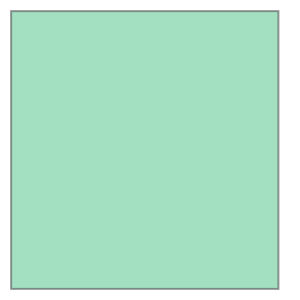

In [5]:
point_rdd.approximateTotalCount
point_rdd.boundary()

In [6]:
point_rdd.analyze()

True

In [7]:
point_rdd.countWithoutDuplicates()

491

In [8]:
point_rdd.getSourceEpsgCode()

'epsg:4326'

In [9]:
point_rdd.getTargetEpsgCode()

'epsg:4326'

In [10]:
point_rdd.rawSpatialRDD.take(1)

[Geometry: Point userData: 0]

In [11]:
point_rdd.rawSpatialRDD.map(lambda x: x.geom.distance(Point(21, 52))).take(5)

[4544640.290851742,
 4544344.718879558,
 4543612.480115721,
 4556892.257844217,
 4557501.513769038]

In [12]:
from shapely.geometry import MultiPoint

In [24]:
point1 = Point(588322, 4502886)
point2 = Point(593116, 4504285)
point3 = Point(588134, 4505220)
point = MultiPoint([point1, point2, point3])
p = [point1, point2, point3]

anchor3 = pd.DataFrame({"wkt":p}, index = [1, 2, 3])
anchor3.to_csv("data/anchor3.csv")

In [25]:
result3 = []
for i in range(3):
    result3 += KNNQuery.SpatialKnnQuery(point_rdd, p[i], 5, False)

In [26]:
result3_pd = pd.DataFrame([[result3[i].geom.wkt] for i in range(15)], index=[i for i in range(15)], columns=["wkt"])
result3_pd.to_csv("data/subway_res3.csv")